In [96]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from environment import Environment
from utils import load_env, plot_env
import os, glob, pickle

In [138]:
def get_sorted_files(path):

    os.chdir(path)
    all_files = glob.glob('*.npz')
    # Sort files by episode number
    episodes = [int(''.join(c for c in f if c.isdigit())) for f in all_files]
    idcs_ep  = [i[0] for i in sorted(enumerate(episodes), key=lambda x:x[1])]
    all_files_sorted = [all_files[i] for i in idcs_ep]

    return all_files_sorted

In [150]:
env_config_file = os.path.join('/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/code/mazes', 'tolman1.txt')
env_config      = load_env(env_config_file)
env             = Environment(**env_config)

num_x_states    = env.num_x_states
num_y_states    = env.num_y_states
num_states      = env.num_states
goal_state      = env.goal_state
start_state     = env.start_state

data_folder     = '/home/georgy/Documents/Dayan_lab/PhD/bandits/maze/data/replay/local/tolman1/2'

with open(os.path.join(data_folder, 'ag.pkl'), 'rb') as f:
    agent = pickle.load(f)

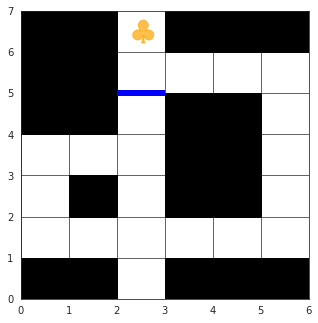

In [314]:
fig = plt.figure(figsize=(4, 4))
ax  = fig.add_axes([0, 0, 1, 1])
plot_env(ax, env)

In [151]:
ordered_files = get_sorted_files(data_folder)

In [206]:
b = np.zeros(len(ordered_files))
m = np.zeros(len(ordered_files))
s = np.zeros(len(ordered_files), dtype=int)
q = []

for idx, f in enumerate(ordered_files):
    data    = np.load(f)
    barrier = data['barrier']
    b[idx]  = barrier
    belief  = data['M']
    m[idx]  = belief
    move    = data['move']
    s[idx]  = int(move[0])
    Q       = data['Q_history']
    q      += [Q] 

In [307]:
thresh1    = np.unique(m)
width      = np.diff(thresh1)
thresh1    = thresh1[:-1]
likes_mean = np.zeros(len(thresh1))
delta_mean = np.zeros(len(thresh1))

for idx1, th1 in enumerate(thresh1):
    idcs   = np.argwhere((m >= th1) & (m <= th1+width[idx1]) & (s == start_state)).flatten()
    tmp    = []
    delta  = []
    
    for idx in idcs:
        this_q  = q[idx]
        Q_after = np.squeeze(this_q[-1, :, :])
        
        if this_q.shape[0] > 1:
            Q_pre  = np.squeeze(this_q[0, :, :])
            
            p1_pre = agent._policy(Q_pre[14, :])[0]
            p2_pre = agent._policy(Q_pre[20, :])[0]
            p3_pre = agent._policy(Q_pre[26, :])[0]
            p4_pre = agent._policy(Q_pre[32, :])[0]
            p5_pre = agent._policy(Q_pre[38, :])[0]
        else:
            Q_pre = None
            
        p1_after = agent._policy(Q_after[14, :])[0]
        p2_after = agent._policy(Q_after[20, :])[0]
        p3_after = agent._policy(Q_after[26, :])[0]
        p4_after = agent._policy(Q_after[32, :])[0]
        p5_after = agent._policy(Q_after[38, :])[0]
        
        tmp     += [p1_after*p2_after*p3_after*p4_after*p5_after]
        
        if Q_pre is not None:
            z = tmp[-1] - p1_pre*p2_pre*p3_pre*p4_pre*p5_pre
            if z != 0:
                delta += [z]
            
    likes_mean[idx1] = np.mean(tmp)
    delta_mean[idx1] = np.mean(delta)

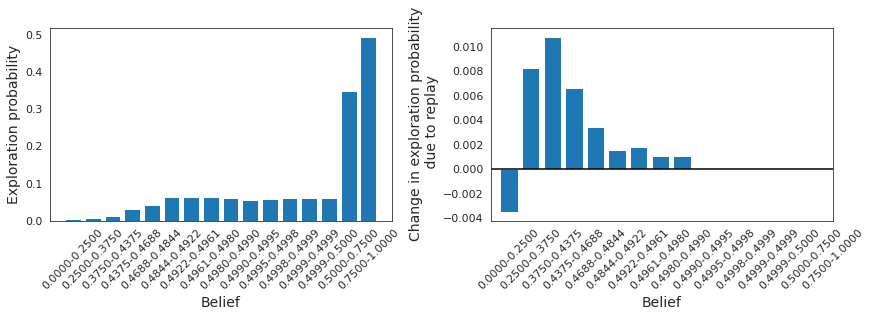

In [308]:
plt.figure(figsize=(12, 4), constrained_layout=True)
x  = np.arange(1, len(thresh1)+1)
xt = ['%.4f-%.4f'%(i, i+width[idx]) for idx, i in enumerate(thresh1)]
plt.subplot(121)
plt.bar(x, likes_mean);
plt.xticks(x, xt, rotation=45, fontsize=11);
plt.yticks(fontsize=11)
plt.ylabel('Exploration probability', fontsize=14);
plt.xlabel('Belief', fontsize=14);

plt.subplot(122)
plt.bar(x, delta_mean);
plt.xticks(x, xt, rotation=45, fontsize=11);
plt.yticks(fontsize=11)
plt.ylabel('Change in exploration probability\n due to replay', fontsize=14);
plt.xlabel('Belief', fontsize=14);
plt.axhline(0, c='k')

In [313]:
occup = np.zeros((len(thresh1), num_states))
for idx1, th1 in enumerate(thresh1):
#     idcs   = np.argwhere((m >= th1) & (m <= th1+width[idx1])).flatten()
    idcs = np.argwhere((m >= th1) & (m <= th1+width[idx1])).flatten()
    states = np.zeros(num_states)
    for idx in idcs:
        states[s[idx]] += 1
    print(np.round(th1, 5), states.sum())
    states /= states.sum()
    occup[idx1, :] = states

0.0 592.0
0.25 238.0
0.375 186.0
0.4375 80.0
0.46875 46.0
0.48438 24.0
0.49219 24.0
0.49609 32.0
0.49805 38.0
0.49902 34.0
0.49951 56.0
0.49976 58.0
0.49988 38.0
0.49994 24.0
0.49997 16.0
0.75 16.0


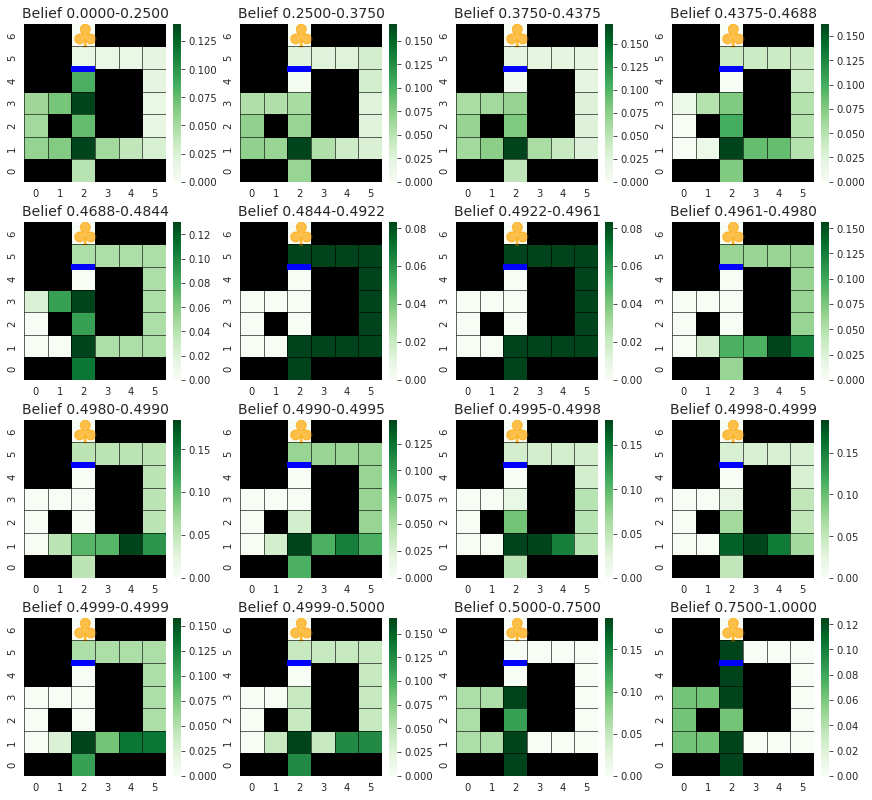

In [306]:
fig = plt.figure(figsize=(12, 11), constrained_layout=True)

num_plots = occup.shape[0]
for i in range(num_plots):
    ax  = fig.add_subplot(4, 4, i+1)
    sns.heatmap(occup[i, :].reshape(num_y_states, num_x_states)[::-1], cmap='Greens', cbar=True, ax=ax)
    plot_env(ax, env)
    plt.title('Belief %.4f-%.4f'%(thresh1[i], thresh1[i]+width[i]), fontsize=14);